In [59]:
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'f:\fashion cnn\fashion\Scripts\python.exe -m pip install --upgrade pip' command.


In [60]:
pip list

Package             Version
------------------- ------------
asttokens           2.4.1
certifi             2024.2.2
charset-normalizer  3.3.2
colorama            0.4.6
comm                0.2.1
contourpy           1.2.0
cycler              0.12.1
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
filelock            3.13.1
fonttools           4.49.0
fsspec              2024.2.0
idna                3.6
importlib-metadata  7.0.1
importlib-resources 6.1.2
ipykernel           6.29.3
ipython             8.18.1
jedi                0.19.1
Jinja2              3.1.3
jupyter-client      8.6.0
jupyter-core        5.7.1
kiwisolver          1.4.5
MarkupSafe          2.1.5
matplotlib          3.8.3
matplotlib-inline   0.1.6
mpmath              1.3.0
nest-asyncio        1.6.0
networkx            3.2.1
numpy               1.26.4
packaging           23.2
parso               0.8.3
pillow              10.2.0
pip                 20.2.3
platformdirs     

You should consider upgrading via the 'f:\fashion cnn\fashion\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available() # checks if CUDA gpu is avaialble

True

In [1]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

NameError: name 'torch' is not defined

In [64]:
transform = transforms.ToTensor()

batch_size = 8
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [65]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [66]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


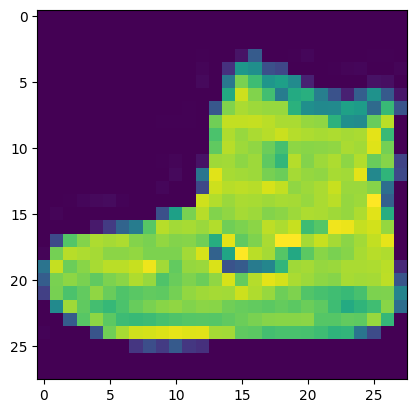

In [67]:
import matplotlib.pyplot as plt
import numpy as np 

np_img = image.numpy()

# print index
print(classes[label])

# print image 28x28 pixel
plt.imshow(np_img.reshape((28,28,1)))

In [68]:
len(trainset), len(testset) # shows # image level pairs

(60000, 10000)

In [69]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [70]:
print(f'Number of batches in the training set: {int(50000 / batch_size)}')

Number of batches in the training set: 6250


In [71]:
print(f'Number of batches in the validation set: {int(10000 / batch_size)}')

Number of batches in the validation set: 1250


In [72]:
type(trainset)

torch.utils.data.dataset.Subset

In [73]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [74]:
import torch.nn as nn # neural network layers
import torch.nn.functional as F # activation functions

class NeuralNet(nn.Module):
    # Tells network what we have
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3) # 2d convolutional layer takes in 1 channel and outputs 256 channels 3x3 window
        self.pool1 = nn.MaxPool2d(2, 2) # max pooling layer with 2x2 window
        
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3) # 2d convolutional layer takes in 256 channels and outputs 512 channels 3x3 window
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2) # 2d convolutional layer takes in 512 channels and outputs 1024 channels 2x2 window
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten() # Flatten super long image to a single vector
        
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3) # dropout layer to prevent overfitting
        
        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)
        
        self.out = nn.Linear(in_features=1024, out_features=10)
        
    # Tells network what to do: watch batches through convolutional layers
    def forward(self, x):
        x = F.relu(self.conv1(x)) # runs x through convolutional layer
        x = self.pool1(x) # runs x through pooling layer
        
        x = F.relu(self.conv2(x)) 
        x = self.pool2(x) 

        x = F.relu(self.conv3(x)) 
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        
        x = self.out(x)
        
        return x

In [75]:
# Instantiate the network

net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [76]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

In [ ]:
num_params = 0
for x in net.parameters():
    num_params += len(torch.flatten(x))
    
print(f'Number of parameters in the network: {num_params:,}')

Number of parameters in the network: 8,536,074


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
def train_one_epoch():
    net.train(True) # set the network to training mode
    
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad() # Reset the gradients to zero
        
        outputs = net(inputs) # shape: (batch_size, 10)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item() # compares the labels to the predictions and sums the correct ones and converts to a number
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels) # compares predictions to labels
        running_loss += loss.item()
        loss.backward() # Go through the loss and go through the network and calculate the gradients
        optimizer.step()
        
        if batch_index % 500 == 499:  # print every 500 batches
            avg_loss_across_batches = running_loss / 500
            avg_acc_across_batches = (running_accuracy / 500) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0.0
            running_accuracy = 0.0
        
print()


In [ ]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [ ]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training') 

Epoch: 1

Batch 500, Loss: 1.185, Accuracy: 54.6%
Batch 1000, Loss: 0.739, Accuracy: 72.8%
Batch 1500, Loss: 0.638, Accuracy: 75.4%
Batch 2000, Loss: 0.609, Accuracy: 76.7%
Batch 2500, Loss: 0.523, Accuracy: 79.7%
Batch 3000, Loss: 0.537, Accuracy: 80.2%
Batch 3500, Loss: 0.499, Accuracy: 81.7%


KeyboardInterrupt: 